# PIT - Práctica 1: Análisis de Series Temporales - Modelos Clásicos

**Profesora: Alicia Lozano Díez**

**Estudiante: Francisco Javier Sáez Maldonado**
 
14 de febrero de 2022


## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento y análisis de señales temporales: descomposición de una serie temporal para el estudio de sus propiedades, ajuste de modelos lineales (ARIMA) y predicción.

### Materiales - Moodle

- Guión (.ipynb) de la práctica
- Datos (.csv): bases de datos _AirPassengers.csv_ y _COVIDVaccinationCZ.csv_.


# 1. Introducción al procesamiento de señales temporales: Air Passengers

## 1.1. Manejo de los datos en Python

Primero vamos a descargar el fichero con los datos de la base de datos *AirPassengers.csv* de Moodle, que contiene los datos del número de pasajeros de una aerolínea para un periodo de tiempo.


A continuación, vamos a leer el fichero *AirPassengers.csv* en Python, con la ayuda de la librería *pandas*.

Lo cargaremos haciendo uso también del módulo de Python *datetime* para operar con este tipo de datos de forma cómoda.

La función definida *parser* nos permitirá cambiar el formato de fecha/tiempo al formato que esperamos encontrar en nuestra base de datos.

In [1]:
from pandas import read_csv
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
 
def parser(x):
    return datetime.strptime(x, '%Y-%m')
 
data = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0, 
                squeeze=True, date_parser=parser)
print(data.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


Podemos visualizar cómo está indexada la estructura de datos, así como el número de datos que tiene nuestra serie temporal.

In [2]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Si queremos acceder a un dato en concreto, por ejemplo, el número de pasajeros del mes de marzo de 1949, podemos hacerlo de la siguiente forma:

In [3]:
data['1949-03-01']


132

O de esta otra:

In [4]:
data[datetime(1949,3,1)]

132

## 1.2. Representación de los datos


El primer paso para analizar una serie temporal es obtener una representación de los datos, para poder hacernos una idea de las características de la serie de forma visual. 

Para ello, podemos utilizar la librería *matplotlib* como sigue:

Text(0.5, 1.0, 'Serie temporal: Air Passengers')

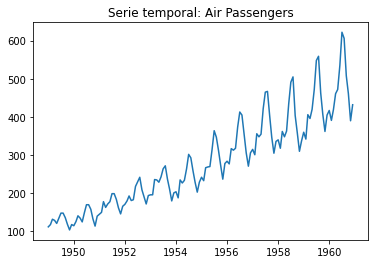

In [5]:
from matplotlib import pyplot as plt
plt.plot(data)
plt.title('Serie temporal: Air Passengers')

## 1.3. Estudio de la estacionariedad de la serie


Algunos de los modelos de análisis de series temporales asumen estacionariedad en las series. Por ello, vamos a ver dos métodos para comprobar si una serie es estacionaria.

Uno de ellos es un análisis más visual: calculamos la media y desviación estándar "móviles" (con una ventana deslizante). 

In [6]:
import pandas as pd

def test_stationarity_1(timeseries,window_size):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation. Window size : {}'.format(window_size))
    plt.show(block=False)

El segundo método consiste en el test estadístico Dickey-Fuller:

In [7]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
def test_stationarity_2(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [8]:
def test_stationarity(timeseries,window_size):
  test_stationarity_1(timeseries,window_size)
  test_stationarity_2(timeseries)

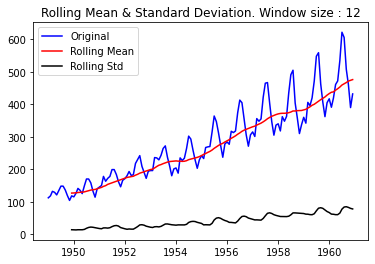

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
test_stationarity(data,12)

**PREGUNTAS**

1.   ¿Qué conclusiones puede extraer del análisis de estacionariedad de la serie original?
2.   ¿Qué diferencias observas al variar el tamaño de la ventana para hacer las medias móviles? Prueba con un par de tamaños, incluye las gráficas obtenidas y explica las diferencias visuales que aprecias.

**Respuestas**

1. Vamos a distinguir entre los dos tipos de *análisis* para dar respuestas a esta pregunta según si el análisis es visual o usando el resultado del test **Dickey-Fuller**.

**a) Análisis visual**

En este análisis podemos ver claramente que la serie **no es estacionaria**. Para que una distribución sea [estacionaria](https://en.wikipedia.org/wiki/Stationary_process), tenemos que tener que la distribución conjunta no condicionada es invariante a traslaciones con el tiempo, es decir, la media y la desviación típica se mantienen constantes en el tiempo. Reafirmamos que en este caso, vemos como la media tiene una tendencia creciente y lo mismo ocurre con la desviación típica.

**b) Análisis con el test Dickey-Fuller**

El test de Dickey-Fuller comprueba la hipótesis nula $H_0$ de que una raíz unitaria está presente en el modelo que hemos supuesto autorregresivo. Sabemos que si un modelo tiene una [raíz unitaria](https://en.wikipedia.org/wiki/Unit_root), el proceso será no estacionario, a pesar de que no siempre tenga una tendencia. Por tanto, la hipótesis alternativa $H_1$ nos indicará si el modelo **s
í** es estacionario. 

Vemos que, en este caso, el valor del obtenido del estadístico $t$ ($\approx 0.81$) queda aproximadamente $0.2$ por debajo del $p-value$. Además, para cualquiera de los niveles de significancia $\alpha$, este $p-value$ será mayor que el valor crítico, por lo que no podemos rechazar la hipótesis nula, lo que nis indicaría que es muy probable que el modelo tenga una raíz unitaria, haciendo a este modelo **no estacionario**.

Esta última afirmación **concuerda** además con lo obtenido en el análisis visual de la serie.

2. Para responder a este apartado, vamos a realizar una serie de gráficas que nos ayuden a ver este resultado.

Lo primero que es conveniente resaltar es que la serie presenta a simple vista cierta **estacionalidad**, es decir, tenemos un comportamiento que se repite aproximadamente cada año. Además, sabiendo que los datos están tomados mes a mes, el tamaño de ventana coincidirá con el número de meses que estamos considerando para calcular la media y desviación típica. Realizamos las gráficas comentadas


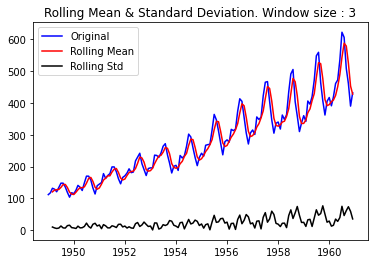

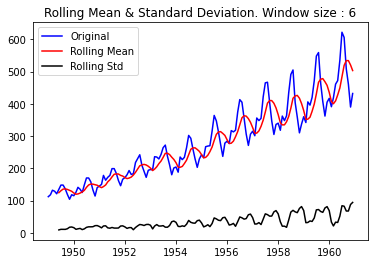

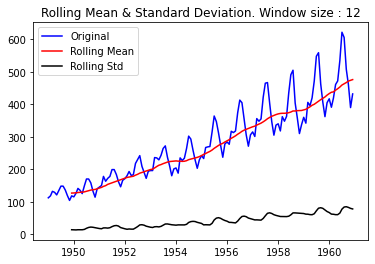

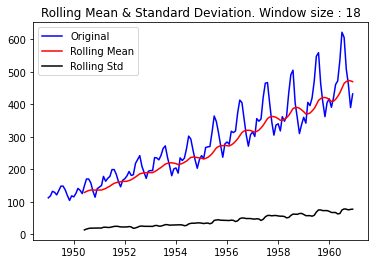

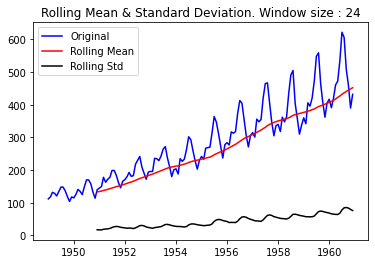

In [10]:
n_months = [3,6,12,18,24]
for months in n_months:
    test_stationarity_1(data,months)
    

Se puede observar cómo cuando tomamos un número de meses (tamaño de ventana) menor, la media se aproxima mucho a la gráfica original y aumenta la varianza, mientras que al aumentar el tamaño hasta una ventana de dos años, se suavizan ambas componentes. Esto tiene sentido, pues al tomar un número de meses más grande estamos reduciendo la componente de **estacionalidad** que tiene la serie que hemos dicho que parece ser a simple vista de un período de $1$ año. Esta se reduce pues estamos tomando valores cuando la *estación* ya se ha repetido más de una vez.

## 1.4. Transformar una serie temporal en estacionaria

Como hemos visto en la teoría, para analizar la serie y poder ajustarle un modelo tipo AR, MA o ARMA, esperamos que la serie a modelar sea estacionaria. 

Para conseguir una serie lo más estacionaria posible, podemos aplicar distintas transformaciones de la serie original. Vamos a ver algunos ejemplos:

a) *Transformaciones simples para reducir el efecto de la tendencia*:

En el caso de los datos del ejemplo, la tendencia es positiva, por lo que podemos aplicar alguna transformación que penalice los valores más altos y menos los más bajos. Es el caso del logaritmo, la raíz cuadrada, etc. 

**PREGUNTA**


1.   Representa a continuación la serie aplicándole una transformación logarítmica. ¿Qué observas?



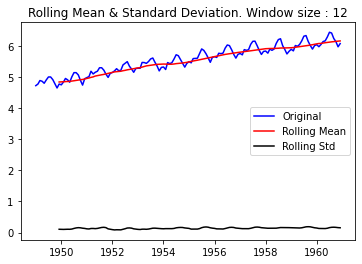

In [11]:
import numpy as np
log_data = data.apply(np.log)
test_stationarity_1(log_data,window_size = 12)

**Respuesta**

Se **observa** que se ha suavizado mucho el crecimiento que tenía la serie, y ahora la **tendencia** de la media es mucho menor que en el caso anterior. Hemos conseguido por tanto lo que se pretendía que era penalizar los valores más altos, haciéndolos más cercanos a los valores más pequeños para frenar esa tendencia creciente y aumentando así la estacionaridad: vemos que la **desviación típica** ya es casi constante y la media tiene un crecimiento muy lento.

En casos más complejos en los que la tendencia no se ve clara (sobre todo en presencia de ruido), se pueden aplicar otros métodos. Uno de ellos es el suavizado como las medias móviles (*moving average*). 

Por ejemplo, podemos aplicar un suavizado con una media con ventana deslizante que tenga en cuenta un año (12 meses). 
Ten en cuenta, que esto implicará que para calcular la media de las primeras muestras, no tengo suficientes datos para la ventana. Esto lo podemos ver en la salida de la media móvil (tendremos que eliminar los *NaN* que aparecen).


**PREGUNTAS**


1.   Aplica dicha media móvil y represéntala junto a los datos. Puede utilizar los datos en escala logarítmica. ¿Esta media móvil representa claramente la tendencia de la serie?

2.   Elimina ahora de la serie original (transformada con el logaritmo si es como la has calculado previamente) la influencia de esta media móvil y representa el resultado. ¿Qué observas ahora?

3.   Realiza el test de estacionariedad de la serie resultante y compáralo con el de la serie original. ¿Qué conclusiones puedes obtener tanto del test visual como del test estadístico?

**RESPUESTAS**

Respondemos una a una las preguntas, incluyendo código entre las respuestas para una mayor comodidad en la lectura.

1. Vamos a aplicar el suavizado mediante media móvil en ambos casos, viendo cuál es el resultado para cada uno de los casos, tanto sin hacer el logaritmo como haciéndolo.



Original data


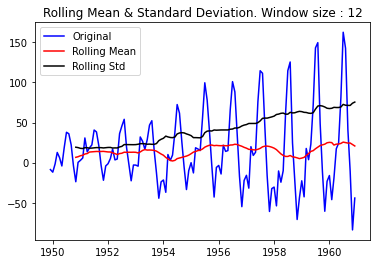



 Logarithm data


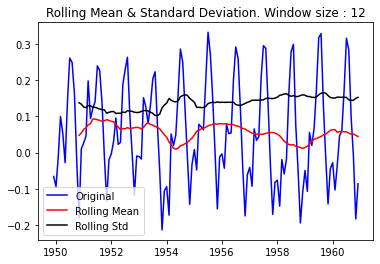

In [12]:
data_sub_mean = (data-data.rolling(window = 12).mean().dropna()).dropna()
log_data_sub_mean = (log_data-log_data.rolling(window = 12).mean().dropna()).dropna()

print("Original data")
test_stationarity_1(data_sub_mean, window_size = 12)
print("\n\n Logarithm data")
test_stationarity_1(log_data_sub_mean, window_size = 12)

Se observa cómo al aplicar este suavizado por media móvil, las medias de las series en ambos casos (tanto la original como a la que le hemos aplicado el logaritmo) mantienen una media que es prácticamente constante, por lo que podemos decir que la media móvil **sí representa** la tendencia de nuestra serie suavizada.

2. Vamos ahora a eliminar el efecto de la media móvil. Para ello, volvemos a sumar en ambas series la media en ventanas de tamaño $12$. Vemos qué efecto tiene.

Dis-apply on Original data


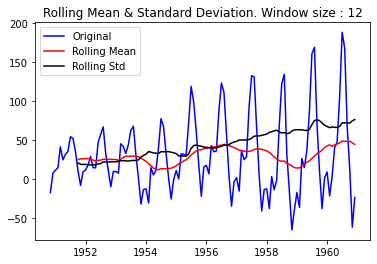



 Dis-apply on Logarithm data


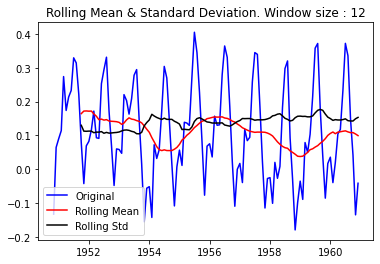

In [13]:
data_dis_apply = (data_sub_mean + data_sub_mean.rolling(window = 12).mean().dropna()).dropna()
log_data_dis_apply = (log_data_sub_mean + log_data_sub_mean.rolling(window = 12).mean().dropna()).dropna()

print("Dis-apply on Original data")
test_stationarity_1(data_dis_apply, window_size = 12)
print("\n\n Dis-apply on Logarithm data")
test_stationarity_1(log_data_dis_apply, window_size = 12)

El efecto obtenido en ambos casos tiene bastante sentido: al aplicar el suavizado por media móvil, hemos convertido las series en series de media cero, por lo que al sumarle la media en intervalos no estaremos sumando prácticamente nada en ambos casos. Vemos que se mantienen bastante similares al caso anterior en su forma, aunque el valor de la media ha aumentado en el caso de la **serie original**, que veíamos que tenía una desviación típica creciente.

3. Por último, vamos a realizar ambos tests sobre las series que han resultado en el apartado (2) anterior para ver qué resultados se obtienen en comparación con el inicial.

Test on Original data


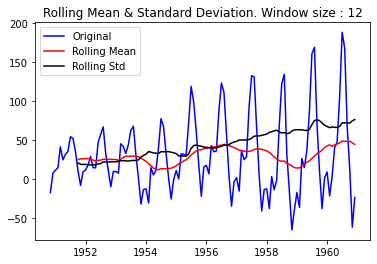

Results of Dickey-Fuller Test:
Test Statistic                  -3.249015
p-value                          0.017317
#Lags Used                      13.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


 Test on Logarithm data


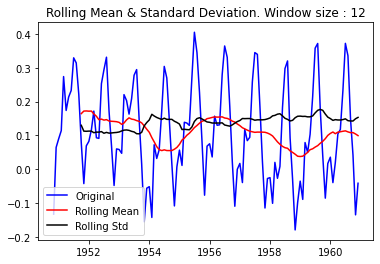

Results of Dickey-Fuller Test:
Test Statistic                  -3.231625
p-value                          0.018226
#Lags Used                      13.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [14]:
print("Test on Original data")
test_stationarity(data_dis_apply, 12)
print("\n\n Test on Logarithm data")
test_stationarity(log_data_dis_apply,12)

Vemos que ahora, en ambos casos, hemos conseguido que el valor del estadístico sea bastante cercano al que tenemos en el valor crítico del $1\%$, y que el $p-value$ es inferior al nivel de significancia estándar $\alpha = 0.05$. Es por ello que en este caso rechazamos la hipótesis nula $H_0$ y podemos decir que el modelo **sí es estacionario**. El **análisis visual** nos muestra lo que ya veníamos mostrando hasta ahora, tenemos media y desviaciones típicas prácticamente constantes, aunque en el caso de los datos originales suavizados por una media móvil sigamos teniendo un ligero crecimiento en la desviación típica.

b) *Diferenciar (derivar)*:

Las técnicas anteriores son sencillas y pueden eliminar parte de la influencia de la tendencia de la serie, pero no suelen ser suficientes cuando se tiene por ejemplo estacionalidad. 

Diferenciar (o derivar) es uno de los métodos más comunes para eliminar la influencia de la tendencia y la estacionalidad en la serie original, mejorando las propiedades de estacionariedad de la serie. 

Podemos tomar la derivada de orden uno de la siguiente manera (partimos de la serie en el dominio logarítmico): 

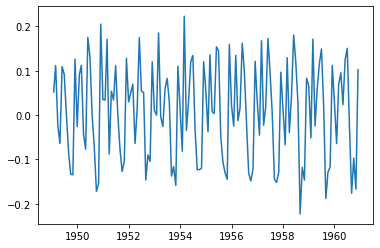

In [15]:
data_log_diff = (log_data - log_data.shift()).dropna()
_ = plt.plot(data_log_diff)

**PREGUNTAS**


1.   ¿Qué observas en la serie resultante?
2.   ¿Es esta serie estacionaria de acuerdo a los criterios anteriores? Incluye los resultados gráficos y del test estadístico e interprétalos.
3. Repite el proceso para una segunda derivada. ¿Qué observas ahora?

**RESPUESTAS**

1. La serie resultante parece, a pripri, una serie estacionaria. Vemos que su media debe ser aproximadamente cero y sus valores no exceden en casi ningún momento el $|0.2|$, por lo que su desviación típica también debe serlo. Además, se observa cierta componente de estacionalidad, aunque es más complicado que en los casos anteriores.

2. Procedemos a hacer los dos tests anteriores para comprobar su estacionaridad:

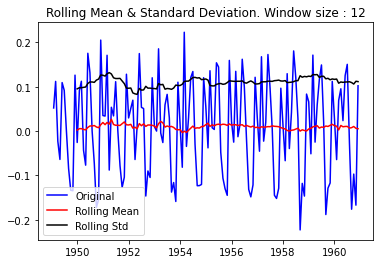

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [16]:
test_stationarity(data_log_diff, 12)

A nivel **visual**, podemos decir que la serie parece estacionaria, pues tenemos sus parámetros media y desviación típica prácticamente constantes.

Sin embargo, el **test Dickey-Fuller** nos indica que, con un nivel de significancia $\alpha = 0.05$, no podemos descartar la hipótesis nula $H_0$ de que nuestra serie temporal no tenga una raíz no unitaria, por lo que a este nivel de significancia el modelo no es estacionario, tendríamos que elevarnos a un nivel de significancia del $10\%$ para que nuestro valor del estadístico quedara por encima del valor crítico calculado

3. Vamos a repetir los cálculos volviendo a diferenciar para ver qué ocurre con la serie.

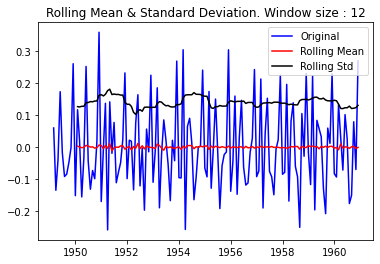

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [17]:
data_log_second_diff = (data_log_diff - data_log_diff.shift()).dropna()
test_stationarity(data_log_second_diff, 12)

Ahora, hemos obtenido que de forma visual la media es prácticamente constante y la desviación típica sigue sin tener mucha variación, por lo que visualmente podemos decir que la serie es **de nuevo estacionaria**.

Usando el **test Dickey-Fuller**, vemos ahora que tenemos un $p-valor$ extremadamente bajo, por lo que en este caso podemos decir con toda seguridad que rechazamos la hipótesis nula $H_0$ y que por tanto nuestro modelo tras aplicar dos diferencias es estacionario.

c) *Descomposición de la serie*:

La mayoría de series pueden descomponerse en tendencia, estacionalidad y residuo, como hemos visto en clase. 

Utilizando la función *seasonal_decompose* del módulo de Python *statsmodels* podemos obtener estas tres componentes y por tanto, modelarlas por separado: 

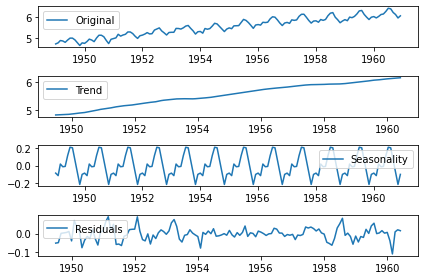

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**PREGUNTAS**

1.   ¿Es la señal residual estacionaria? Realiza el test y comenta los resultados.



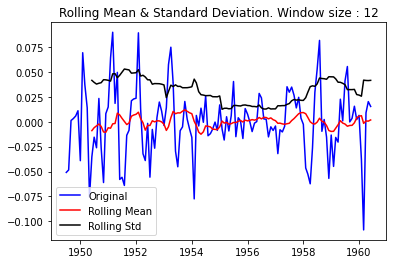

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [19]:
test_stationarity(residual.dropna(), 12)

El resultado sobre ambos test que la serie **es estacionaria**. En concreto:

- En el test **visual**, tenemos que tanto la media como la desviación típica de la serie residual es prácticamente constante. Ambas tienen variaciones debido al ruido, pero son de órdenes de magnitud muy bajos, al igual que los propios residuos, por lo que pdoemos decir que sí es estacionaria.

- En el test **Dickey-Fuller**, vemos que obtenemos un $p-value$ muy inferior a casi cualquier nivel de significancia que podamos tomar, por lo que descartaríamos la hipótesis nula $H_0$ y podemos afirmar que la serie es estacionaria.

## 1.5. Modelado ARIMA y predicción

Uno de los modelos clásicos para series temporales vistos en clase es el modelo ARIMA, que permite derivar *d* veces, y aplicar *p* coeficientes autorregresivos (AR) y *q* términos de error (shocks, provenientes de la parte MA) en la combinación lineal.  

Para determinar el valor de los parámetros *p* y *q*, podemos hacer uso de las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). 

Si calculamos dichas funciones para la serie derivada previamente, obtenemos lo siguiente:

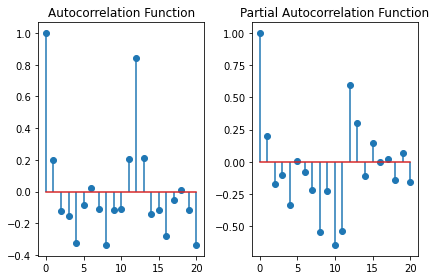

In [20]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

def plot_acf_pacf(data_acf,data_pacf,orig_data,c_interval = False):
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.stem(data_acf,use_line_collection=True)
    if c_interval:
        plt.axhline(y=0,linestyle='--',color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(orig_data)),linestyle='--',color='gray')
        plt.axhline(y=1.96/np.sqrt(len(orig_data)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.stem(lag_pacf,use_line_collection=True)
    if c_interval:
        plt.axhline(y=0,linestyle='--',color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(orig_data)),linestyle='--',color='gray')
        plt.axhline(y=1.96/np.sqrt(len(orig_data)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    

lag_acf = acf(data_log_diff, nlags=20, fft=False)
lag_pacf = pacf(data_log_diff, nlags=20, method='ols')
plot_acf_pacf(lag_acf,lag_pacf,data_log_diff)


Podemos añadir además un intervalo de confianza a ambos lados del valor cero, de tal manera que el primer valor de retardo que cruce ese intervalo por arriba en la función de PACF será el valor de *p*, y de ACF, será *q*.

Para los niveles de confianza estándar, el valor del límite del intervalo de confianza al 95% es 1.96. Suponiendo desviación estándar unidad, el límite estaría en (-1.96/sqrt(N), 1.96/sqrt(N)), donde N es el número de puntos. 

Si incluimos estos límites en la figura anterior, podemos obtener una buena aproximación de los valores de *p* y *q* para el modelo ARIMA:

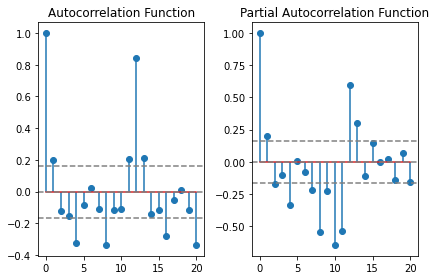

In [21]:
plot_acf_pacf(lag_acf,lag_pacf,data_log_diff,c_interval = True)


**PREGUNTAS**


1.   ¿Qué valores de *p* y *q* utilizarías para un primer modelo ARIMA de acuerdo a las representaciones anteriores?


**RESPUESTA**

Sabemos que se eligen en general:

- El $p$ tal que el valor de la PACF es mayor que el valor límite del intervalo establecido para la PACF tiene desplazamiento $p$
- El $q$ tal que el valor de la ACF es mayor que el valor límite del intervalo establecido para la ACF tiene desplazamiento $q$.

En este caso, vemos que para desplazamiento $1$, ambos casos superan ese umbral, por lo que podemos tomar $p=q=1$. Podríamos considerar valores en los que la función de autocorrelación es mayor, pero esto supondría ajustar un número **mayor** de parámetros y hacer el modelo más complejo, por lo que nos quedaremos con el modelo simple.



Una vez elegidos los valores de *p* y *q*, podemos utilizar también la derivación interna de la clase ARIMA (*d*) o aplicarlo sobre la serie previamente derivada con valor de *d=0*. 

A continuación, importamos el modelo ARIMA de la siguiente manera. 

Este modelo tiene como argumentos los datos, y el orden: 

model = ARIMA(datos, order = (p,d,q))

In [22]:
from statsmodels.tsa.arima.model import ARIMA

**PREGUNTAS**


1.   A continuación, completa los valores de p, d y q y utiliza el siguiente código para ajustar un modelo tipo AR. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

2.    Repite el código con los valores de los parámetros correspondientes para ajustar un modelo MA. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

3.    Repite nuevamente el código para combinar los modelos anteriores (ARMA). Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

4.   De acuerdo a los valores de RSS, ¿cuál dirías que es el modelo que mejor se ajusta a los datos?

**RESPUESTAS**

A partir de este punto suponemos que la serie sobre la que queremos ajustar los modelos es **la serie a la que le hemos aplicado el logaritmo y una diferencia**, así que normalmente escribiremos $d=0$ pues la diferencia ya está aplicada. 

En general, sabemos que un modelo ARIMA tiene 3 parámetros:

- $p$ que indicará el orden del proceso AR que se va a aplicar
- $q$ que indicará el orden del Moving Average que se va a aplicar
- $d$ que indicará el número de diferenciaciones que se van a hacer.


1. Comenzamos ajustando un modelo AR. Si ponemos entonces un $p$ que queramos y a continuación $q = d = 0$, tendremos un modelo AR de orden $p$. Hemos visto que era conveniente usar $p = 1$, por lo que ajustaremos este modelo.

In [23]:
def plot_ARIMA(data, results, title):
    _ = plt.plot(data,color = "blue", label = "Original data")
    _ = plt.plot(results.fittedvalues, color='red',label = "Predictions")
    _ = plt.title(title + ' RSS: %.4f'% sum((results.fittedvalues-data)**2))
    _ = plt.legend()
    

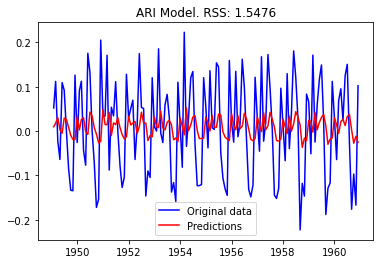

In [24]:
p = 1
d = 0
q = 0

data_log_diff = data_log_diff.resample('MS').last().dropna()


# AR
model = ARIMA(data_log_diff, order=(p, d, q))  
results_AR = model.fit()
plot_ARIMA(data_log_diff, results_AR, title = "ARI Model.")
# RSS: Residual sum of squares

En principio, parece que este modelo AR no ajusta muy bien a los datos, las predicciones se alejan de los valores reales y son prácticamente constantes, teniendo un error de $1.54$ lo cual parece bastante grande considerando la baja escala de los datos.

2. Ajustamos un modelo MA ahora. Del mismo modo que antes, basta elegir $q = 1$ y $p = d = 0$ para ajustar este modelo utilizando las funciones que tenemos. Lo ejecutamos para hallar el error:

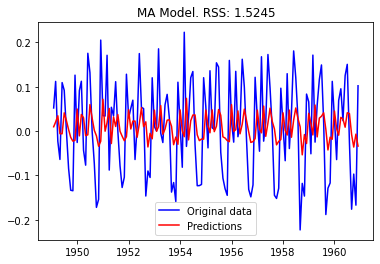

In [25]:
p = 0
d = 0
q = 1

# MA
model = ARIMA(data_log_diff, order=(p, d, q),freq = 'MS', enforce_invertibility=True)  
results_MA = model.fit() 
plot_ARIMA(data_log_diff,results_MA, title = "MA Model.")

Como vemos, este modelo tampoco ajusta  bien a los datos que estamos considerando. En concreto, tenemos un error de $1.52$ y las predicciones parecen también mucho más constantes que los datos.

3. Vamos a combinar ahora los dos modelos anteriores para aplicar un modelo ARMA sobre la serie diferenciada (por lo que estaríamos haciendo ARIMA). Para ello, tenemos que considerar $p=q=1$ y realizar las mismas acciones que anteriormente.

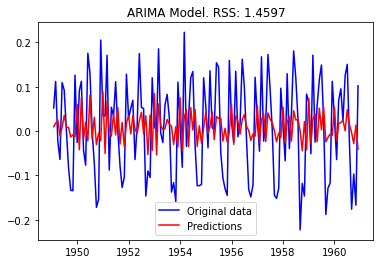

In [26]:
p = 1
d = 0
q = 1

# AR
model = ARIMA(data_log_diff, order=(p, d, q),freq = 'MS', enforce_invertibility=True)  
results_ARIMA = model.fit() 
plot_ARIMA(data_log_diff,results_ARIMA, title = "ARIMA Model.")

Vemos que en este caso obtenemos unas predicciones ciertamente algo mejores, aunque siguen estando lejos de los datos diferenciados originales. El error en este caso baja unas centésimas, situándose en $1.45$.


4. Siguiendo los resultados de RSS obtenidos, vemos que el modelo ARMA (ARIMA, si consideramos que estamos usando la serie derivada previamente), es el modelo que menor RSS obtiene por lo que sería el modelo que mejor ajusta nuestros datos. 

---

Por último, para predecir valores en el espacio original, tenemos que deshacer las transformaciones realizadas hasta el momento. 

Primero, tomamos los valores ajustados por el modelo (predicciones) y los guardamos como serie temporal. 

Estos valores empiezan en el segundo mes, puesto que hemos tomado diferencias (derivada) de orden 1.

In [27]:
# Predicciones en el espacio original
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())


Month
1949-02-01    0.009797
1949-03-01    0.017616
1949-04-01    0.025227
1949-05-01   -0.010229
1949-06-01    0.008525
Freq: MS, dtype: float64


Segundo, deshacemos la operación de diferencias (en escala logarítmica), con una suma acumulativa y añadiéndoles el valor "base" (primer elemento de la serie). 

In [28]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009797
1949-03-01    0.027412
1949-04-01    0.052639
1949-05-01    0.042410
1949-06-01    0.050935
Freq: MS, dtype: float64


In [29]:
predictions_ARIMA_log = pd.Series(log_data[0], index=log_data.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.728295
1949-03-01    4.745911
1949-04-01    4.771138
1949-05-01    4.760909
dtype: float64


Finalmente, aplicamos la función exponencial (inversa del logaritmo).

Podemos calcular el error cuadrático medio en el espacio original. 

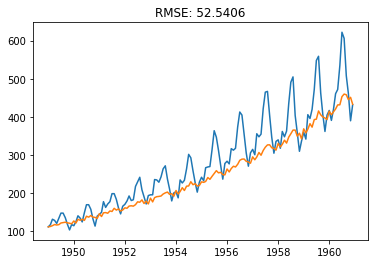

In [30]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
_ = plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

Vemos que el modelo tras deshacer la derivación capta bien la tendencia de la serie, aunque los picos por estación no consigue captarlos de igual manera. El RMSE obtiene un valor de $52$ que, a priori, parece un valor alto.


# 2. Aplicación a otros datos: Vacunación COVID República Checa


Vamos a cargar ahora los datos sobre la vacunación COVID de República Checa (*COVIDVaccinationCZ.csv*):

Esta base de datos, contiene los datos de vacunación de República Checa desde el 27 de diciembre de 2020 hasta el 7 de febrero de 2022. 

In [31]:
from pandas import read_csv
#from pandas import datetime
from matplotlib import pyplot
from datetime import datetime
 
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')
 
vaccin = read_csv('COVIDVaccinationCZ.csv', header=0, parse_dates=[0], index_col=0,date_parser=parser).squeeze("columns")
print(data.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


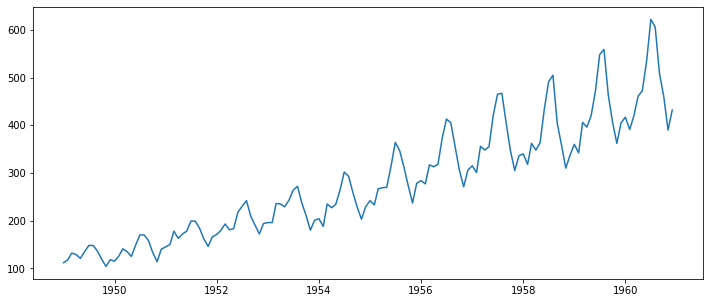

In [32]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(data)

**PREGUNTAS**

Utilizando las herramientas del apartado 1, realiza el análisis de esta serie (puedes utilizar un intervalo de ella o la serie completa). 

En concreto:
1.   Analiza la estacionariedad de esta serie. 
2.   ¿Qué transformaciones puedes realizar para hacerla más estacionaria? Prueba algunas y justifica si consigues una serie más estacionaria. 
3.   Ajusta un modelo ARIMA, y calcula el error de predicción. 


## Estacionariedad

Comenzamos analizando la **estacionariedad** de la serie. Como hemos visto en los datos, estos están tomados día a día, por lo que debemos considerar ahora ventanas de tamaño diferente al anterior. Valores que podrían ser adecuados podrían ser $7$ o $30$. Realizaremos este análisis con un estudio semanal, es decir, usando ventanas de tamaño $7$.

Ejecutamos ahora ambos test (visual y Dickey-Fuller) y analizamos sus resultados. 

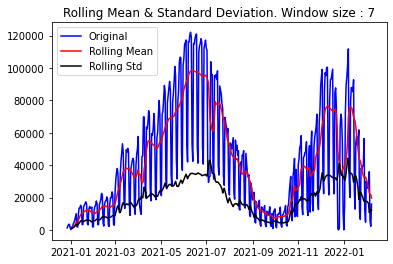

Results of Dickey-Fuller Test:
Test Statistic                  -2.052545
p-value                          0.264019
#Lags Used                      14.000000
Number of Observations Used    393.000000
Critical Value (1%)             -3.447099
Critical Value (5%)             -2.868923
Critical Value (10%)            -2.570703
dtype: float64


In [33]:
test_stationarity(vaccin,7)

El resultado es el siguiente:

- En el test visual, observamos como tanto la media como la desviación típica de la serie se alejan bastante de ser constantes, por lo que visualmente podemos decir que **no es estacionaria**.

- En el test de Dickey-Fuller, vemos que obtenemos un $p-value$ bastante superior al nivel típico de confianza ($\alpha = 0.05$), por lo que rechazamos la hipótesis nula $H_0$ y afirmamos que la serie **no es estacionaria**.

Ambos tests nos indican que la serie **no es estacionaria**, así que tendremos que aplicar transformaciones que nos hagan esta serie estacionaria. 

## Transformaciones sobre la serie

Vamos a aplicar las transformaciones. A priori, no conocemos si alguna transformación concreta nos va a dar unos resultados mejores que en el caso anterior. Es por ello que vamos a comenzar realizando el logaritmo igual que en el caso anterior y ver qué resultados obtenemos sobre la serie.  

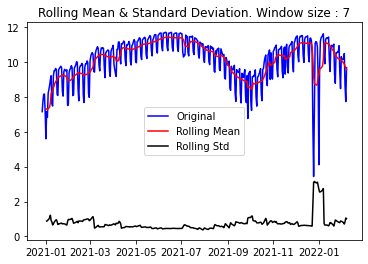

Results of Dickey-Fuller Test:
Test Statistic                  -3.447442
p-value                          0.009444
#Lags Used                       7.000000
Number of Observations Used    400.000000
Critical Value (1%)             -3.446804
Critical Value (5%)             -2.868793
Critical Value (10%)            -2.570634
dtype: float64


In [34]:
log_vaccin = vaccin.apply(np.log)
test_stationarity(log_vaccin,window_size = 7)

Tras aplicar el logaritmo, obtenemos los siguientes resultados:

- **El  test visual**, se obtiene que la serie sigue sin ser estacionaria, pues la media y la varianza no son ninguna de las dos constantes.
- **El test de Dickey-Fuller** sin embargo, nos dice lo contrario: obtenemos un $p-value = 0.009 < 0.05 = \alpha$, por lo que rechazamos la hipótesis nula $H_0$ y podemos decir que la serie según este test **es estacionaria**.

Obtenemos resultados diferentes según el test, por lo que podríamos decir que quizá necesitemos más transformaciones para conseguir que la serie sea adecuada para modelarla por un modelo ARIMA.

Vamos a aplicar el **suavizado por media móvil** a ambas series (tanto la original como el logaritmo) para si obtenemos mejores resultados.

In [35]:
vaccin_sub_mean = (vaccin-vaccin.rolling(window = 7).mean().dropna()).dropna()
log_vaccin_sub_mean = (log_vaccin-log_vaccin.rolling(window = 7).mean().dropna()).dropna()

Original data


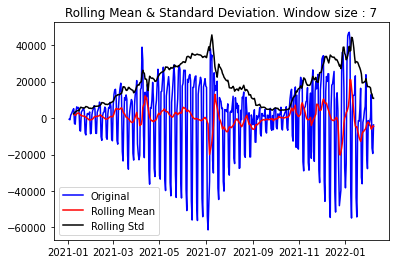

Results of Dickey-Fuller Test:
Test Statistic                -5.970004e+00
p-value                        1.946403e-07
#Lags Used                     1.400000e+01
Number of Observations Used    3.870000e+02
Critical Value (1%)           -3.447361e+00
Critical Value (5%)           -2.869037e+00
Critical Value (10%)          -2.570764e+00
dtype: float64


 Logarithm data


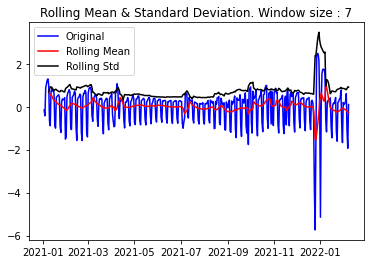

Results of Dickey-Fuller Test:
Test Statistic                -6.266222e+00
p-value                        4.107849e-08
#Lags Used                     1.400000e+01
Number of Observations Used    3.870000e+02
Critical Value (1%)           -3.447361e+00
Critical Value (5%)           -2.869037e+00
Critical Value (10%)          -2.570764e+00
dtype: float64


In [36]:
print("Original data")
test_stationarity(vaccin_sub_mean, window_size = 7)
print("\n\n Logarithm data")
test_stationarity(log_vaccin_sub_mean, window_size = 7)

En el caso de los datos originales, el suavizado por media móvil hace que nuestra serie sea estacionaria para el test Dickey-Fuller, pues como vemos tenemos un $p-value < \alpha$. Sin embargo, el test visual nos indica que la serie no tiene media ni desviación típica constantes, por lo que no sería estacionaria para ese test. 

En el caso de los datos logarítmicos, obtenemos un curioso resultado y es que prácticamente se consigue la estacionariedad **visual** de la serie, pero tenemos un pequeño período en el que hay una gran oscilación (se podría considerar un *outlier*) de la media y la desviación típica, haciendo que nuestra serie siga sin ser estacionaria.


Puesto que aplicar el logaritmo nos acerca más a la estacionariedad, descartamos ahora el suavizado por media móvil. Seguimos con el siguiente paso que nos puede ayudar a eliminar la estacionaridad del modelo: **diferenciar** el mismo. Puesto que ya hemos comprobado que aplicar el logaritmo nos acerca de forma significativa a la estacionariedad de la serie, continuamos el análisis usando solo estos datos.

Differentiation Logarithm data


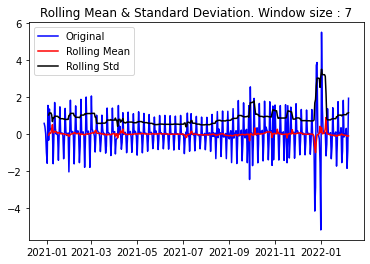

Results of Dickey-Fuller Test:
Test Statistic                -1.094922e+01
p-value                        8.885075e-20
#Lags Used                     6.000000e+00
Number of Observations Used    4.000000e+02
Critical Value (1%)           -3.446804e+00
Critical Value (5%)           -2.868793e+00
Critical Value (10%)          -2.570634e+00
dtype: float64


In [37]:
vaccin_log_diff = (log_vaccin - log_vaccin.shift()).dropna()


print("Differentiation Logarithm data")
test_stationarity(vaccin_log_diff, window_size = 7)

Podemos observar como tenemos un caso basatnte parecido al que teníamos en el paso anterior: la serie es casi estacionaria salvo por un punto que hace que, en el entorno de ese punto, la desviación típica se aleje mucho de ser constante, por lo que seguimos sin tener estacionariedad.

Vamos a ver si aplicando una segunda derivada obtenemos un resultado más apropiado de estacionariedad. Imprimimos ahora únicamente el test visual pues sabemos que el de Dickey-Fuller nos indicará que la serie es estacionaria.

Second Differentiation Lo-garithm data


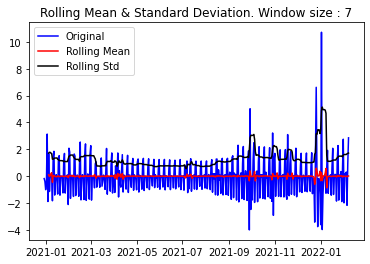

In [38]:
vaccin_log_second_diff = (vaccin_log_diff - vaccin_log_diff.shift()).dropna()

print("Second Differentiation Lo-garithm data")
test_stationarity_1(vaccin_log_second_diff, window_size = 7)

Vemos que el problema que teníamos antes persiste: visualmente tenemos una dificultad para conseguir que la desviación típica y la media sean constantes cerca de Enero de 2022.   Sabemos que, habitualmente, realizando $d=1$ o $d=2$ diferenciaciones, solemos obtener que la serie ya es estacionaria. Sin embargo, en este caso hemos obtenido que esto no es así, incluso hemos **probado** con una tercera diferenciación y aún no hemos conseguido una serie estacionaria visualmente.

Sin embargo, en el test estadístico de Dickey-Fuller hemos aceptado que la serie **es estacionaria** desde que aplicamos el logaritmo, por lo que consideraremos que estos datos son adecuados para aplicar un modelo ARIMA. 

## Ajuste de modelo ARIMA

Queremos ahora ajustar un modelo ARIMA$(p,d,q)$ a nuestros datos. Para ello, debemos hallar los parámetros $(p,d,q)$.  Para el parámetro $d$, hemos visto que con realizar una diferenciación, el logaritmo de los datos es prácticamente estacionario, por lo que tomaremos $d=1$.

Para hallar $p$ y $q$, dibujamos la ACF y la PACF.

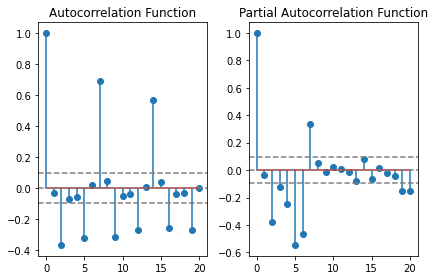

In [39]:
lag_acf = acf(vaccin_log_diff, nlags=20, fft=False)
lag_pacf = pacf(vaccin_log_diff, nlags=20, method='ols')
plot_acf_pacf(lag_acf,lag_pacf,vaccin_log_diff,c_interval = True)


Podemos sacar las sigiuentes conclusiones:


- Observamos también que tenemos picos de alta autocorrelación semanales, es decir, cada $7$ lags. Es por ello que sería bueno utilizar también una componente de estacionalidad para modelar esta serie (SARIMA). En este caso, como de momento no vamos a usarla, tomaremos $p = q = 7$, donde tenemos valores altos de la PACF y ACF respectivamente.

Si considerásemos un modelo que tenga en cuenta la estacionalidad (que suponemos que tiene un período $S = 7$), los valores que deberíamos considerar serían diferentes:

- Mirando la PACF, obtenemos que con $p=5$ tenemos el punto en el que hay máxima PACF, por lo que utilizaríamos esta $p$ para la parte que no considera la estacionalidadsuperamos por primera vez este umbral y podríamos usar este valor para ajustar el modelo ARMA sobre la serie diferenciada.
- Mirando la ACF, razonamos de igual modo para decir que sería adecuado usar $q = 2$ pues el valor en el que la ACF toma su máximo antes del primer período en $lag = 7$.

Vamos a comenzar ajustando el modelo ARIMA con los parámetros $(p,d,q) = (7,1,7)$.

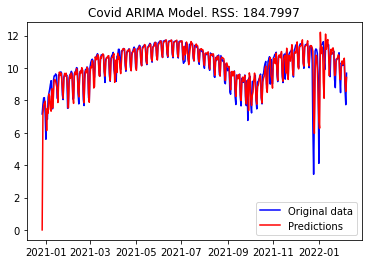

In [40]:
p = 7
d = 1
q = 7

warnings.filterwarnings('ignore')
model = ARIMA(log_vaccin, order=(p, d, q),freq = 'D')  
results_covid = model.fit() 
plot_ARIMA(log_vaccin,results_covid, title = "Covid ARIMA Model.")

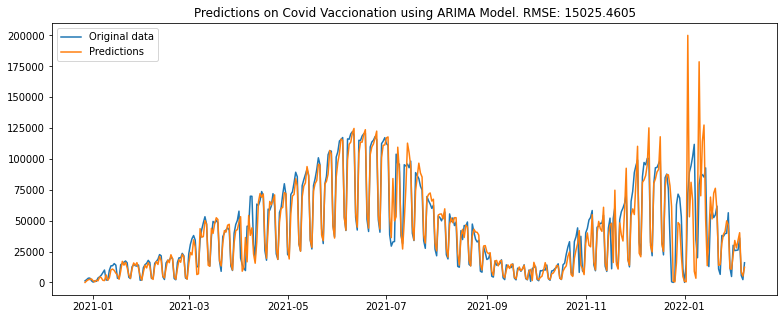

In [41]:
# Undo operations
predictions_covid = pd.Series(results_covid.fittedvalues, copy=True)
predictions_covid_cumsum = predictions_covid.cumsum()

predictions_ARIMA = np.exp(predictions_covid)
plt.figure(figsize=(13,5))
_ = plt.plot(vaccin,label ="Original data")
_ = plt.plot(predictions_ARIMA, label = "Predictions")
_ = plt.title('Predictions on Covid Vaccionation using ARIMA Model. RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-vaccin)**2)/len(vaccin)))
_ = plt.legend()


## Ajuste modelo SARIMA

Anteriormente, hemos comentado que la serie tiene una componente de estacionalidad que debería ser modelada. Vamos a comprobar esto, dividimos primero la serie en sus componentes y dibujamos únicamente la componente de estacionalidad:

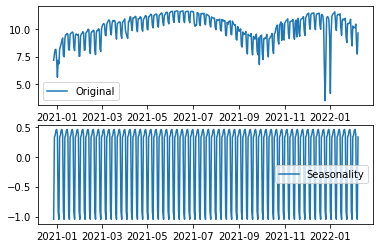

In [42]:
decomposition_vaccin = seasonal_decompose(log_vaccin)

seasonal_vaccin = decomposition_vaccin.seasonal

_ = plt.subplot(211)
_ = plt.plot(log_vaccin, label='Original')
_ = plt.legend(loc='best')
_ = plt.subplot(212)
_ = plt.plot(seasonal_vaccin,label='Seasonality')
_ = plt.legend(loc='best')

Vemos que hay una clara componente de **seasonality** que debemos modelar.  Tenemos que hallar para ello unos nuevos parámetros $(P,D,Q)$. 

Comenzamos hallando el $D$, es decir, si tenemos que derivar esta componente de estacionalidad. Para ello, vemos si esta serie estacional es estacionaria.

In [43]:
test_stationarity_2(seasonal_vaccin)

Results of Dickey-Fuller Test:
Test Statistic                -3.072061e+15
p-value                        0.000000e+00
#Lags Used                     6.000000e+00
Number of Observations Used    4.010000e+02
Critical Value (1%)           -3.446763e+00
Critical Value (5%)           -2.868775e+00
Critical Value (10%)          -2.570624e+00
dtype: float64


Obtenemos que usando el test *Dickey-Fuller*, podemos rechazar la hipótesis nula $H_0$ y decir que nuestra serie es estacionaria, por lo que usaremos $D = 0$.

Miramos ahora la ACF y la PACF para determinar $P$ y $Q$.

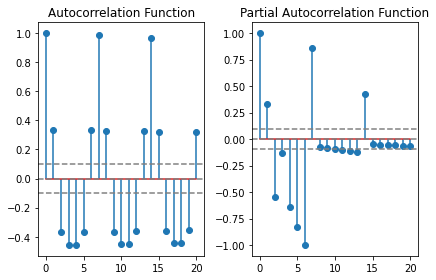

In [44]:
lag_acf = acf(seasonal_vaccin, nlags=20, fft=False)
lag_pacf = pacf(seasonal_vaccin, nlags=20, method='ols')
plot_acf_pacf(lag_acf,lag_pacf,seasonal_vaccin,c_interval = True)


Podemos ver que, si nos olvidamos del tiempo en el que se completa el período ($lag = 7$):

- Tenemos un mínimo (máximo en valor absoluto) en la PACF en lag $5$, por lo que usaremos $5$ como valor de $P$
- También tenemos un mínimo en lag $3$ en la ACF, por lo que usaremos $2$ como valor de $Q$.

Por tanto, los parámetros de la parte **seasonal** que usaremos serán $(P,D,Q) = (5,0,2)$. Necesitamos un parámetro adicional $M$ que indica el número de periodos por **season** (temporada), que hemos predicho que es $7$.

Procedemos a ajustar el modelo SARIMA

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_arima = (5,1,2)
order_seasonal = (6,0,3,7)

covid_seasonal = SARIMAX(log_vaccin, order=order_arima, seasonal_order=order_seasonal, freq='D')
results_covid_sarima = covid_seasonal.fit()

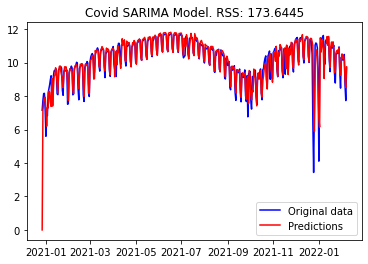

In [46]:
plot_ARIMA(log_vaccin,results_covid_sarima, title = "Covid SARIMA Model.")

Podemos observar que las predicciones se ajustan razonablemente bien al modelo con los datos a los que se les ha aplicado el logaritmo. En efecto, además, hay una leve disminución en el error de ajuste, por lo que este modelo SARIMA **mejora** al modelo ARIMA sobre nuestros datos (ARIMA obtenía $RSS = 184$ en frente de este $173$ que obtiene SARIMA).

Restaría aplicar una exponenciación a los datos para eliminar el efecto del logaritmo y poder comprobar así el error en términos del **RMSE**. El resultado es el siguiente:

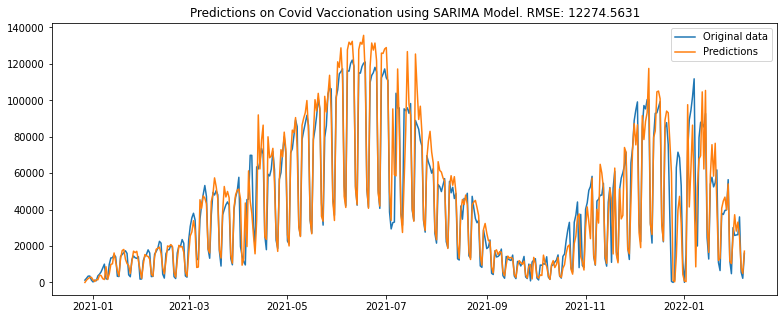

In [47]:
# Undo operations
predictions_covid_sarima = pd.Series(results_covid_sarima.fittedvalues, copy=True)

predictions_SARIMA = np.exp(predictions_covid_sarima)
plt.figure(figsize=(13,5))
_ = plt.plot(vaccin,label ="Original data")
_ = plt.plot(predictions_SARIMA, label = "Predictions")
_ = plt.title('Predictions on Covid Vaccionation using SARIMA Model. RMSE: %.4f'% np.sqrt(sum((predictions_SARIMA-vaccin)**2)/len(vaccin)))
_ = plt.legend()


Como podemos observar,este modelo SARIMA tiene un RMSE de $12254$, que es razonablemente menor al valor de $15025$ que obteníamos ajustando el modelo ARIMA. Además, se obtiene una mayor estabilidad en las predicciones cerca del *posible outlier* que habíamos mencionado anteriormente cerca de Enero de 2022.

Aún así, hemos de mencionar que claramente hemos aumentado ligeramente el número de parámetros, por lo que tiene sentido que se estén ajustando mejor los datos en este caso. De todos modos, como el aumento en el número de parámetros no es muy significativo, concluimos que es mejor en este caso utilizar un **modelo SARIMA** para modelar los datos relacionados con la vacunación contra el covid en República Checa.